In [ ]:
#Modele de predictions pour GHGEmissions(MetricTonsCO2e)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

data2015 = pd.read_csv('data2015_noEss.csv', sep=',')
data2015 = data2015.drop(columns='Unnamed: 0')
data2015 = data2015.dropna()

data2016 = pd.read_csv('data2016_noEss.csv', sep=',')
data2016 = data2016.drop(columns='Unnamed: 0')
data2016 = data2016.dropna()

In [ ]:
#------------------------------#

In [ ]:
#GHGEmissions(MetricTonsCO2e) - sans ENERGYSTARScore

In [2]:
#Features utilisees selon l'analyse effectuee dans 'features_pertinentes_GHGEmissions.ipynb' + GHGEmissions (cible de la prediction)
data2015 = data2015[['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking','GHGEmissions(MetricTonsCO2e)']]

#On effectue une transformation x -> log(x + 1) (on evite les 0 se transformant en moins l'infini)
data2015['LargestPropertyUseTypeGFA'] = np.log(data2015['LargestPropertyUseTypeGFA'] + 1)
data2015['SecondLargestPropertyUseTypeGFA'] = np.log(data2015['SecondLargestPropertyUseTypeGFA'] + 1)
data2015['PropertyGFAParking'] = np.log(data2015['PropertyGFAParking'] + 1)
data2015['GHGEmissions(MetricTonsCO2e)'] = np.log(data2015['GHGEmissions(MetricTonsCO2e)'] + 1)

#On traite le cas de valeurs infinies creees par l'ordinateur, lors de la transformation des features quantitatives
data2015.replace([np.inf, -np.inf], np.nan)
data2015 = data2015.dropna()

In [3]:
#Features utilisees selon l'analyse effectuee dans 'features_pertinentes_GHGEmissions.ipynb' + GHGEmissions (cible de la prediction)
data2016 = data2016[['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking','GHGEmissions(MetricTonsCO2e)']]

#On effectue une transformation x -> log(x + 1) (on evite les 0 se transformant en moins l'infini)
data2016['LargestPropertyUseTypeGFA'] = np.log(data2016['LargestPropertyUseTypeGFA'] + 1)
data2016['SecondLargestPropertyUseTypeGFA'] = np.log(data2016['SecondLargestPropertyUseTypeGFA'] + 1)
data2016['PropertyGFAParking'] = np.log(data2016['PropertyGFAParking'] + 1)
data2016['GHGEmissions(MetricTonsCO2e)'] = np.log(data2016['GHGEmissions(MetricTonsCO2e)'] + 1)

#On traite le cas de valeurs infinies creees par l'ordinateur, lors de la transformation des features quantitatives
data2016.replace([np.inf, -np.inf], np.nan)
data2016 = data2016.dropna()

In [4]:
#On definit les colonnes et les transformations pour les colonnes quantitatives:
col_quanti = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking']
transfo_quanti = StandardScaler()

#On definit les colonnes et les transformations pour les variables qualitatives:
col_quali = ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']
transfo_quali = OneHotEncoder(handle_unknown='ignore', sparse=False)

#On definit l'objet de la classe ColumnTransformer qui va permettre d'appliquer toutes les etapes:
preparation = ColumnTransformer([('quanti', transfo_quanti , col_quanti), ('quali', transfo_quali , col_quali)])

#------------------------------#

#On utilise les donnees contenues dans data2015:
x_train, x_test, y_train, y_test = train_test_split(data2015.iloc[:, :-1], data2015['GHGEmissions(MetricTonsCO2e)'], random_state=44)

In [ ]:
#------------------------------#

In [5]:
#modele lineaire: Baseline (entrainement avec data2015)

#On cree un pipeline integrant l'estimateur ColumnTransformer et le modele LinearRegression
modele_linReg_noEss = Pipeline(steps=[('preparation', preparation), ('linreg', LinearRegression())])

#Apprentissage du modele
modele_linReg_noEss.fit(x_train, y_train)

#R2 pour les jeux d'entrainement et de test:
print("Train set score = {:.2f}".format(modele_linReg_noEss.score(x_train, y_train)))
print("Test set score  = {:.2f}".format(modele_linReg_noEss.score(x_test, y_test)))

Train set score = 0.71
Test set score  = -2710091511797080129536.00


In [ ]:
#------------------------------#
#------------------------------#

In [ ]:
#methode ensembliste - foret aleatoire (entrainement avec data2015)

In [ ]:
#------------------------------#

In [6]:
#On cree un pipeline de traitement integrant la preparation et le modele GradientBoostingRegressor:
pipe = Pipeline(steps=[('preparation', preparation), ('gradientboostingregressor', GradientBoostingRegressor(random_state=0))])

#On definit les hyperparametres a faire varier:
param_grid = {'gradientboostingregressor__n_estimators': [400, 500, 600], 'gradientboostingregressor__max_depth': [1, 2, 3], 'gradientboostingregressor__learning_rate': [0.01, 0.1, 1]}

#On cree le modele de grille
modele_noEss = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

#On entraine le modele
modele_noEss.fit(x_train, y_train)

print(modele_noEss.best_params_)

{'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 500}


In [7]:
print("Train set score = {:.2f}".format(modele_noEss.score(x_train, y_train)))
print("Test set score  = {:.2f}".format(modele_noEss.score(x_test, y_test)))

Train set score = 0.71
Test set score  = 0.53


In [8]:
#data2016 utilise comme test set:
print("Test set score  = {:.2f}".format(modele_noEss.score(data2016.iloc[:, :-1], data2016['GHGEmissions(MetricTonsCO2e)'])))

Test set score  = 0.66


In [ ]:
#------------------------------#
#------------------------------#

Text(0, 0.5, 'y_pred')

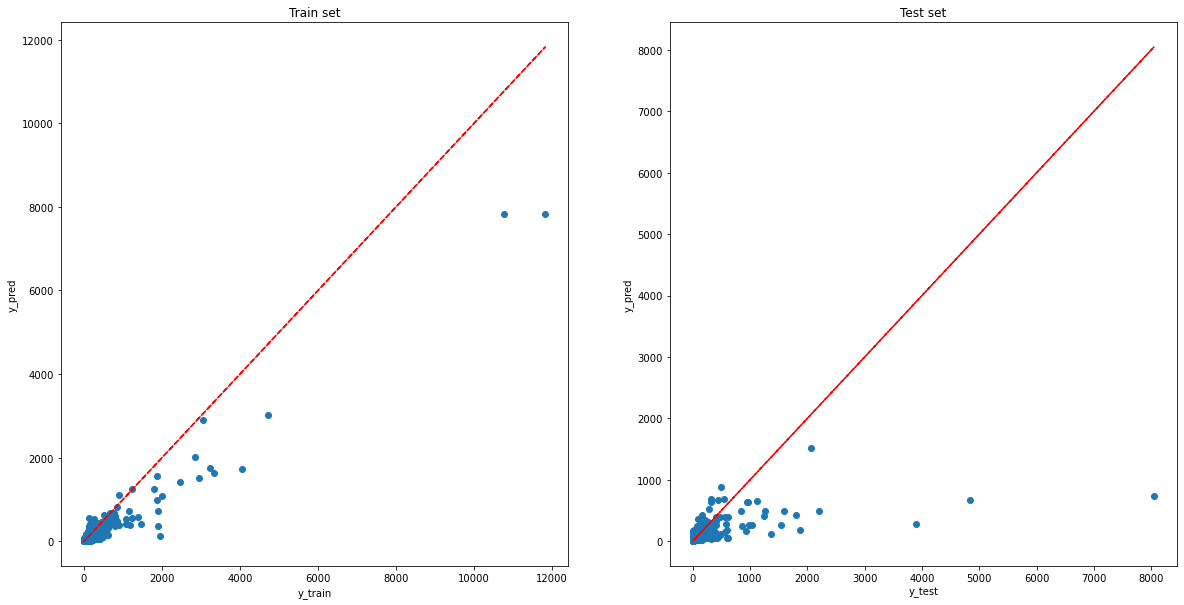

In [9]:
#Representation des predictions en fonction des observations (modele sans ENERGYSTARScore) :
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(np.exp(y_train.values) - 1, np.exp(modele_noEss.predict(x_train)) - 1)
axes[0].plot(np.exp(y_train.values) - 1, np.exp(y_train.values) - 1, '--', c='r')
axes[0].set_title('Train set')
axes[0].set_xlabel('y_train')
axes[0].set_ylabel('y_pred')

axes[1].scatter(np.exp(y_test.values) - 1, np.exp(modele_noEss.predict(x_test)) - 1)
axes[1].plot(np.exp(y_test.values) - 1, np.exp(y_test.values) - 1, '--', c='r')
axes[1].set_title('Test set')
axes[1].set_xlabel('y_test')
axes[1].set_ylabel('y_pred')

In [ ]:
#On constate une plutot bonne prediction pour les valeurs de GHGEmissions(MetricTonsCO2e) < 800 (environ), pour le jeu de test.
#Au-dela de cette valeur, les predictions sont de moins en moins precises.

In [ ]:
#------------------------------#

In [ ]:
#GHGEmissions(MetricTonsCO2e) - avec ENERGYSTARScore

In [10]:
#Pris en compte de l'ENERGYSTARScore:
data2015_ess = pd.read_csv('data2015_ess.csv', sep=',')
data2015_ess = data2015_ess.drop(columns='Unnamed: 0')

data2016_ess = pd.read_csv('data2016_ess.csv', sep=',')
data2016_ess = data2016_ess.drop(columns='Unnamed: 0')

In [11]:
#Features utilisees selon l'analyse effectuee dans 'features_pertinentes_GHGEmissions.ipynb' + ENERGYSTARScore + GHGEmissions (cible de la prediction)
data2015_ess = data2015_ess[['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking', 'ENERGYSTARScore', 'GHGEmissions(MetricTonsCO2e)']]

#On effectue une transformation x -> log(x + 1) (on evite les 0 se transformant en moins l'infini)
data2015_ess['LargestPropertyUseTypeGFA'] = np.log(data2015_ess['LargestPropertyUseTypeGFA'] + 1)
data2015_ess['SecondLargestPropertyUseTypeGFA'] = np.log(data2015_ess['SecondLargestPropertyUseTypeGFA'] + 1)
data2015_ess['PropertyGFAParking'] = np.log(data2015_ess['PropertyGFAParking'] + 1)
data2015_ess['GHGEmissions(MetricTonsCO2e)'] = np.log(data2015_ess['GHGEmissions(MetricTonsCO2e)'] + 1)

#On traite le cas de valeurs infinies creees par l'ordinateur, lors de la transformation des features quantitatives
data2015_ess.replace([np.inf, -np.inf], np.nan)
data2015_ess = data2015_ess.dropna()

In [12]:
#Features utilisees selon l'analyse effectuee dans 'features_pertinentes_GHGEmissions.ipynb' + ENERGYSTARScore + GHGEmissions (cible de la prediction)
data2016_ess = data2016_ess[['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking', 'ENERGYSTARScore','GHGEmissions(MetricTonsCO2e)']]

#On effectue une transformation x -> log(x + 1) (on evite les 0 se transformant en moins l'infini)
data2016_ess['LargestPropertyUseTypeGFA'] = np.log(data2016_ess['LargestPropertyUseTypeGFA'] + 1)
data2016_ess['SecondLargestPropertyUseTypeGFA'] = np.log(data2016_ess['SecondLargestPropertyUseTypeGFA'] + 1)
data2016_ess['PropertyGFAParking'] = np.log(data2016_ess['PropertyGFAParking'] + 1)
data2016_ess['GHGEmissions(MetricTonsCO2e)'] = np.log(data2016_ess['GHGEmissions(MetricTonsCO2e)'] + 1)

#On traite le cas de valeurs infinies creees par l'ordinateur, lors de la transformation des features quantitatives
data2016_ess.replace([np.inf, -np.inf], np.nan)
data2016_ess = data2016_ess.dropna()

In [ ]:
#------------------------------#

In [13]:
#On definit les colonnes et les transformations pour les colonnes quantitatives:
col_quanti = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFAParking', 'ENERGYSTARScore']
transfo_quanti = StandardScaler()

#On definit les colonnes et les transformations pour les variables qualitatives:
col_quali = ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']
transfo_quali = OneHotEncoder(handle_unknown='ignore', sparse=False)

#On definit l'objet de la classe ColumnTransformer qui va permettre d'appliquer toutes les etapes:
preparation = ColumnTransformer([('quanti', transfo_quanti , col_quanti), ('quali', transfo_quali , col_quali)])

#------------------------------#

#On utilise les donnees contenues dans data2015:
x_train, x_test, y_train, y_test = train_test_split(data2015_ess.iloc[:, :-1], data2015_ess['GHGEmissions(MetricTonsCO2e)'], random_state=44)

In [ ]:
#------------------------------#

In [14]:
#modele lineaire: Baseline (entrainement avec data2015)

#On cree un pipeline integrant l'estimateur ColumnTransformer et le modele LinearRegression
modele_linReg_Ess = Pipeline(steps=[('preparation', preparation), ('linreg', LinearRegression())])

#Apprentissage du modele
modele_linReg_Ess.fit(x_train, y_train)

#R2 pour les jeux d'entrainement et de test:
print("Train set score = {:.2f}".format(modele_linReg_Ess.score(x_train, y_train)))
print("Test set score  = {:.2f}".format(modele_linReg_Ess.score(x_test, y_test)))

Train set score = 0.74
Test set score  = -21644812513532841984.00


In [ ]:
#------------------------------#
#------------------------------#

In [ ]:
#methode ensembliste - foret aleatoire (entrainement avec data2015)

In [15]:
#On cree un pipeline de traitement integrant la preparation et le modele GradientBoostingRegressor:
pipe = Pipeline(steps=[('preparation', preparation), ('gradientboostingregressor', GradientBoostingRegressor(random_state=0))])

#On definit les hyperparametres a faire varier:
param_grid = {'gradientboostingregressor__n_estimators': [100, 150, 200], 'gradientboostingregressor__max_depth': [2, 3, 4], 'gradientboostingregressor__learning_rate': [0.01, 0.1, 1]}

#On cree le modele de grille
modele_Ess = GridSearchCV(pipe, param_grid, cv=5)

#On entraine le modele
modele_Ess.fit(x_train, y_train)

print(modele_Ess.best_params_)

{'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 150}


In [16]:
print("Train set score = {:.2f}".format(modele_Ess.score(x_train, y_train)))
print("Test set score  = {:.2f}".format(modele_Ess.score(x_test, y_test)))

Train set score = 0.81
Test set score  = 0.62


In [17]:
#data2016 utilise comme test set:
print("Test set score  = {:.2f}".format(modele_Ess.score(data2016_ess.iloc[:, :-1], data2016_ess['GHGEmissions(MetricTonsCO2e)'])))

Test set score  = 0.76


In [ ]:
#------------------------------#

In [ ]:
#Avec l'ENERGYSTARScore, la precision sur le jeu de test gagne 9 points.

In [ ]:
#------------------------------#
#------------------------------#

Text(0, 0.5, 'y_pred')

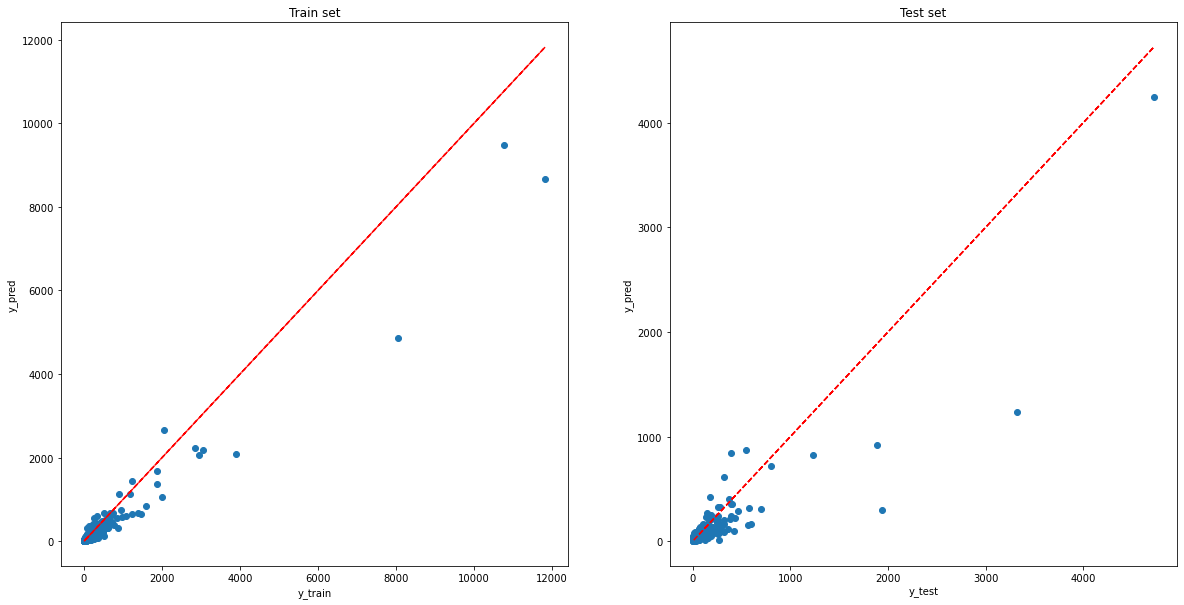

In [18]:
#Representation des predictions en fonction des observations (modele avec ENERGYSTARScore) :
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(np.exp(y_train.values) - 1, np.exp(modele_Ess.predict(x_train)) - 1)
axes[0].plot(np.exp(y_train.values) - 1, np.exp(y_train.values) - 1, '--', c='r')
axes[0].set_title('Train set')
axes[0].set_xlabel('y_train')
axes[0].set_ylabel('y_pred')

axes[1].scatter(np.exp(y_test.values) - 1, np.exp(modele_Ess.predict(x_test)) - 1)
axes[1].plot(np.exp(y_test.values) - 1, np.exp(y_test.values) - 1, '--', c='r')
axes[1].set_title('Test set')
axes[1].set_xlabel('y_test')
axes[1].set_ylabel('y_pred')

In [ ]:
#On constate une plutot bonne prediction pour les valeurs de GHGEmissions(MetricTonsCO2e) < 500 (environ), pour le jeu de test.
#Au-dela de cette valeur, les predictions sont de moins en moins precises.